In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import timm
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, accuracy_score
import numpy as np
import os
import shutil
import random
import time
from torch.utils.tensorboard import SummaryWriter
import csv
import pandas as pd
from collections import Counter

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# def save_filenames_to_csv(root_dir, output_csv):
#     # Open the CSV file for writing
#     with open(output_csv, mode='w', newline='', encoding='utf-8') as file:
#         writer = csv.writer(file)
#         writer.writerow(['Folder', 'Filename'])  # Write header
        
#         # Iterate through each folder
#         for folder in os.listdir(root_dir):
#             folder_path = os.path.join(root_dir, folder)
            
#             # Check if it's a directory
#             if os.path.isdir(folder_path):
#                 for filename in os.listdir(folder_path):
#                     file_path = os.path.join(folder_path, filename)
#                     if os.path.isfile(file_path):  # Ensure it's a file
#                         writer.writerow([folder, filename])

# if __name__ == "__main__":
#     root_directory = "./realwaste-main/RealWaste"  # Change this to your dataset's root directory
#     output_csv_file = "dataset.csv"  # CSV file to store results
#     save_filenames_to_csv(root_directory, output_csv_file)
#     print(f"File list saved to {output_csv_file}")


In [ ]:
df = pd.read_csv("../dataset.csv")
df.head()

,Category,Filename
0,Cardboard,Cardboard_1.jpg
1,Cardboard,Cardboard_10.jpg
2,Cardboard,Cardboard_100.jpg
3,Cardboard,Cardboard_101.jpg
4,Cardboard,Cardboard_102.jpg


In [8]:
folder_counts = df["Category"].value_counts()
print(folder_counts)

Category
Plastic                921
Metal                  790
Paper                  500
Miscellaneous Trash    495
Cardboard              461
Vegetation             436
Glass                  420
Food Organics          411
Textile Trash          318
Name: count, dtype: int64


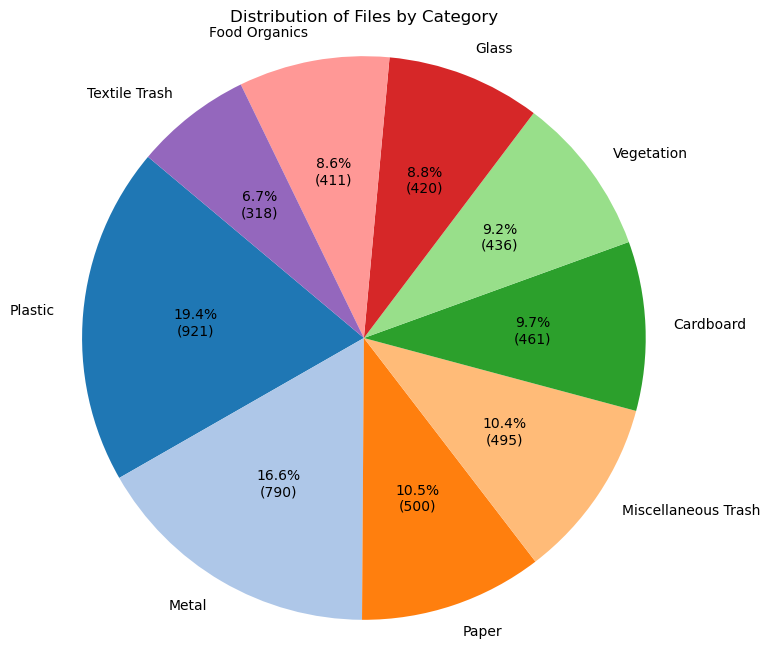

In [9]:
category_counts = df['Category'].value_counts()

# Total count (for percentage calculation)
total = category_counts.sum()

# Custom autopct function
def autopct_format(pct):
    count = int(round(pct * total / 100.0))
    return f"{pct:.1f}%\n({count})"

# Plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    category_counts.values,
    labels=category_counts.index,
    autopct=autopct_format,
    startangle=140,
    shadow=False,
    colors=plt.cm.tab20.colors,  # Use a colormap for colors
   
)
plt.title('Distribution of Files by Category')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [10]:
# import os
# import shutil
# import pandas as pd
# import uuid
# from sklearn.utils import resample

# # Paths
# image_dir = '../realwaste-main/RealWaste'
# df = pd.read_csv('../dataset.csv')

# # Target size per category
# target_size = 500  

# # Output directories
# balanced_image_dir = 'balanced_images'
# os.makedirs(balanced_image_dir, exist_ok=True)

# # New CSV storage
# balanced_data = []

# # Resample images for each category
# for category in df['Category'].unique():
#     category_df = df[df['Category'] == category]
#     category_dir = os.path.join(image_dir, category)

#     # Create category folder
#     category_balanced_dir = os.path.join(balanced_image_dir, category)
#     os.makedirs(category_balanced_dir, exist_ok=True)

#     # Resampling: Upsample or Downsample
#     if len(category_df) < target_size:
#         # Oversampling: Allow duplicates
#         resampled_category = resample(category_df, replace=True, n_samples=target_size, random_state=42)
#         oversampling = True
#     else:
#         # Downsampling: No duplicates
#         resampled_category = resample(category_df, replace=False, n_samples=target_size, random_state=42)
#         oversampling = False

#     # Copy images & update CSV
#     for idx, row in resampled_category.iterrows():
#         filename = row['Filename']
#         src_path = os.path.join(category_dir, filename)

#         # Check if file exists
#         if not os.path.exists(src_path):
#             print(f"Missing file: {src_path}")
#             continue  

#         # Modify filename for duplicates
#         if oversampling:
#             filename_new = f"{uuid.uuid4().hex}_{filename}"  # Unique filenames for duplicates
#         else:
#             filename_new = filename  # No modification for downsampling

#         dst_path = os.path.join(category_balanced_dir, filename_new)

#         # Copy image
#         shutil.copy(src_path, dst_path)

#         # Store updated CSV row
#         balanced_data.append({"Filename": filename_new, "Category": category})

# # Save new CSV file
# balanced_df = pd.DataFrame(balanced_data)
# balanced_df.to_csv("balanced_dataset.csv", index=False)

# # Verify new dataset distribution
# print("\nBalanced dataset distribution:")
# for category in os.listdir(balanced_image_dir):
#     category_path = os.path.join(balanced_image_dir, category)
#     if os.path.isdir(category_path):
#         print(f"{category}: {len(os.listdir(category_path))} files")

# print("\n✅ New balanced dataset saved as 'balanced_dataset.csv' 🚀")


In [11]:

# # Path to the balanced dataset directory
# balanced_image_dir = 'balanced_images'

# # Initialize total file counter
# total_files = 0

# # Dictionary to store per-category counts
# category_counts = {}

# # Walk through each category folder
# for category in os.listdir(balanced_image_dir):
#     category_path = os.path.join(balanced_image_dir, category)
    
#     # Check if it's a directory
#     if os.path.isdir(category_path):
#         file_count = len(os.listdir(category_path))  # Count files in the category
#         category_counts[category] = file_count
#         total_files += file_count

# # Print per-category counts
# print("\nCategory-wise file count:")
# for category, count in category_counts.items():
#     print(f"{category}: {count}")

# # Print total file count
# print(f"\nTotal files in 'balanced_images': {total_files}")


In [12]:
from sklearn.model_selection import train_test_split

# # Load your dataset
df = pd.read_csv('../balanced_dataset.csv')

# Perform the first split (80% train, 20% val+test)
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['Category'], random_state=42)

# Perform the second split (50% val, 50% test) on the temp_df
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['Category'], random_state=42)

# # Save the splits to CSV files
# train_df.to_csv('train_set.csv', index=False)
# val_df.to_csv('val_set.csv', index=False)
# test_df.to_csv('test_set.csv', index=False)

# print(f"Training set size: {len(train_df)}")
# print(f"Validation set size: {len(val_df)}")
# print(f"Test set size: {len(test_df)}")


In [13]:
# # Paths
# csv_path = "train_set.csv"  # Path to the CSV file
# source_folder = "../balanced_images"  # Path to the folder with subfolders (containing images)
# destination_folder = "../processed/train"  # Path to the destination folder where new structure will be created

# # Read CSV
# df = pd.read_csv(csv_path)

# # Create destination directories for categories
# categories = df['Category'].unique()
# for category in categories:
#     category_folder = os.path.join(destination_folder, category)
#     if not os.path.exists(category_folder):
#         os.makedirs(category_folder)

# # Iterate through the CSV and copy images to the new folder structure
# for _, row in df.iterrows():
#     category = row['Category']
#     filename = row['Filename']
    
#     # Source path: Find the image in the respective subfolder
#     source_image_path = os.path.join(source_folder, category, filename)
    
#     # Destination path: Copy the image to the new category folder
#     destination_image_path = os.path.join(destination_folder, category, filename)
    
#     # Check if the source image exists
#     if os.path.exists(source_image_path):
#         shutil.copy(source_image_path, destination_image_path)
#         print(f"Copied {filename} to {destination_image_path}")
#     else:
#         print(f"Warning: {source_image_path} does not exist.")

# print("Image copying complete.")


In [14]:
# # Paths
# csv_path = "../train_set.csv"  # Path to the CSV file
# source_folder = "../processed/train"  # Path to the folder with subfolders (containing images)

# # Read CSV
# df = pd.read_csv(csv_path)

# # Check if all images are present in the respective folders
# missing_images = []

# for _, row in df.iterrows():
#     category = row['Category']
#     filename = row['Filename']
    
#     # Source path: Find the image in the respective subfolder
#     source_image_path = os.path.join(source_folder, category, filename)
    
#     # Check if the image exists
#     if not os.path.exists(source_image_path):
#         missing_images.append((category, filename))

# # Output results
# if missing_images:
#     print("The following images are missing:")
#     for category, filename in missing_images:
#         print(f"Category: {category}, Filename: {filename}")
# else:
#     print("All images are present.")


In [ ]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Hyperparameters based on the CoAtNet paper
BATCH_SIZE = 32
NUM_EPOCHS = 50
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-5
IMAGE_SIZE = 224  # Standard input size for CoAtNet
NUM_CLASSES = 9   # Your dataset has 9 categories
WARMUP_EPOCHS = NUM_EPOCHS // 10  # Warmup for the first 10% of epochs
MODEL_NAME = "coatnet_0_rw_224.sw_in1k"  

In [ ]:
# Define transforms (Data Augmentation & Normalization)
transform = transforms.Compose([
    transforms.RandomResizedCrop(IMAGE_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(180),  # Random rotation
    transforms.ColorJitter(saturation=0.05, hue=0.05),  # Random color jitter
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

evaluation_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load dataset (RealWaste dataset)
dataset_path = "../processed"  # Path to the processed dataset
train_dataset = datasets.ImageFolder(root=os.path.join(dataset_path, "train"), transform=transform)
val_dataset = datasets.ImageFolder(root=os.path.join(dataset_path, "val"), transform=evaluation_transform)
test_dataset = datasets.ImageFolder(root=os.path.join(dataset_path, "test"), transform=evaluation_transform)

# DataLoader

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

# Calculate steps per epoch for the learning rate scheduler
steps_per_epoch = len(train_loader)
total_steps = steps_per_epoch * NUM_EPOCHS
warmup_steps = steps_per_epoch * WARMUP_EPOCHS

# Get class names
class_names = train_dataset.classes
print(f"Training on {len(train_dataset)} images with {NUM_CLASSES} classes: {class_names}")
print(f"Validation on {len(val_dataset)} images")
print(f"Testing on {len(test_dataset)} images")

Training on 3600 images with 9 classes: ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']
Validation on 450 images
Testing on 450 images


In [17]:
# Check what is returned from the DataLoader
for data in train_loader:
    print(f"Data type: {type(data)}, Length: {len(data)}")
    if isinstance(data, tuple):
        print(f"First element shape: {data[0].shape}, Second element: {data[1]}")
    break  # Only check the first batch


Data type: <class 'list'>, Length: 2


In [18]:
for inputs, labels in train_loader:
    print(f"inputs shape: {inputs.shape}, labels shape: {labels.shape}")
    break  # Stop after the first batch

inputs shape: torch.Size([32, 3, 224, 224]), labels shape: torch.Size([32])


In [ ]:
def create_model():
    # Load CoAtNet model from timm
    model = timm.create_model(
        MODEL_NAME,
        pretrained=True,
        num_classes=NUM_CLASSES
    )
    return model

# Learning rate scheduler with warmup
def get_lr(step, total_steps, warmup_steps, base_lr):
    if step < warmup_steps:
        return base_lr * step / warmup_steps
    else:
        # Cosine decay after warmup as per paper
        return 0.5 * base_lr * (1 + np.cos(np.pi * (step - warmup_steps) / (total_steps - warmup_steps)))
    
# Function to calculate gradient norm
def get_gradient_norm(model):
    total_norm = 0
    for p in model.parameters():
        if p.grad is not None:
            param_norm = p.grad.data.norm(2)
            total_norm += param_norm.item() ** 2
    return total_norm ** 0.5

# Function to plot learning rate schedule
def plot_lr_schedule():
    steps = np.arange(0, total_steps)
    lr_values = [get_lr(step, total_steps, warmup_steps, LEARNING_RATE) for step in steps]
    
    plt.figure(figsize=(10, 5))
    plt.plot(steps, lr_values)
    plt.axvline(x=warmup_steps, color='r', linestyle='--', label=f'Warmup End ({WARMUP_EPOCHS} epochs)')
    plt.xlabel('Training Steps')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate Schedule: Warmup + Cosine Decay')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{MODEL_NAME}_lr_schedule.png")
    plt.show()

# Function to plot per-class metrics
def plot_per_class_metrics(precision, recall, f1, accuracy, class_names):
    metrics = np.array([precision, recall, f1, accuracy]).T
    
    fig, ax = plt.subplots(figsize=(12, 8))
    x = np.arange(len(class_names))
    width = 0.2
    
    # Plot bars for each metric
    ax.bar(x - width*1.5, metrics[:, 0], width, label='Precision')
    ax.bar(x - width/2, metrics[:, 1], width, label='Recall')
    ax.bar(x + width/2, metrics[:, 2], width, label='F1 Score')
    ax.bar(x + width*1.5, metrics[:, 3], width, label='Accuracy')
    
    ax.set_xlabel('Classes')
    ax.set_ylabel('Score')
    ax.set_title('Per-Class Performance Metrics')
    ax.set_xticks(x)
    ax.set_xticklabels(class_names, rotation=45, ha='right')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig(f"{MODEL_NAME}_per_class_metrics.png")
    plt.show()

# Function to plot gradient norms over training
def plot_gradient_norms(gradient_norms):
    plt.figure(figsize=(10, 5))
    plt.plot(gradient_norms)
    plt.xlabel('Training Steps')
    plt.ylabel('Gradient Norm')
    plt.title('Gradient Norm During Training')
    plt.grid(True, alpha=0.3)
    plt.yscale('log')  # Log scale often helps visualize gradient magnitudes
    plt.tight_layout()
    plt.savefig(f"{MODEL_NAME}_gradient_norms.png")
    plt.show()
    
# Training function
def train_model():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    model = create_model()
    model = model.to(device)
    
    # Use weighted loss
    criterion = nn.CrossEntropyLoss()
    
    # Optimizer: AdamW as mentioned in paper
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    
    # Lists to store metrics
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    learning_rates = []
    gradient_norms = []
    
    # Per-class metrics storage
    class_precision_history = {class_name: [] for class_name in class_names}
    class_recall_history = {class_name: [] for class_name in class_names}
    class_f1_history = {class_name: [] for class_name in class_names}
    class_accuracy_history = {class_name: [] for class_name in class_names}
    
    # Visualize the learning rate schedule before training
    plot_lr_schedule()
    
    # Training loop
    global_step = 0
    best_val_acc = 0.0
    
    for epoch in range(NUM_EPOCHS):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        epoch_gradient_norms = []
        
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Train]")
        for inputs, labels in train_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Update learning rate
            current_lr = get_lr(global_step, total_steps, warmup_steps, LEARNING_RATE)
            for param_group in optimizer.param_groups:
                param_group['lr'] = current_lr
            
            learning_rates.append(current_lr)
            
            # Forward pass
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            
            # Calculate gradient norm before optimizer step
            grad_norm = get_gradient_norm(model)
            gradient_norms.append(grad_norm)
            epoch_gradient_norms.append(grad_norm)
            
            optimizer.step()
            
            # Update metrics
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            # Update progress bar
            train_bar.set_postfix({
                'loss': running_loss / (train_bar.n + 1),
                'acc': 100. * correct / total,
                'lr': current_lr,
                'grad_norm': grad_norm
            })
            
            global_step += 1
        
        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        
        # Report average gradient norm for the epoch
        avg_grad_norm = np.mean(epoch_gradient_norms)
        print(f"Average gradient norm for epoch {epoch+1}: {avg_grad_norm:.4f}")
        
        # Validation phase
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Val]")
            for inputs, labels in val_bar:
                inputs, labels = inputs.to(device), labels.to(device)
                
                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                # Update metrics
                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
                
                # Store predictions and labels for confusion matrix and per-class metrics
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                
                # Update progress bar
                val_bar.set_postfix({
                    'loss': running_loss / (val_bar.n + 1),
                    'acc': 100. * correct / total
                })
        
        val_loss = running_loss / len(val_loader)
        val_acc = 100. * correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        
        print(f"Epoch {epoch+1}/{NUM_EPOCHS} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        
        # Calculate per-class metrics
        precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average=None, zero_division=0)
        
        # Calculate per-class accuracy
        class_accuracies = []
        for i in range(NUM_CLASSES):
            class_mask = np.array(all_labels) == i
            if np.sum(class_mask) > 0:  # Only calculate if we have examples of this class
                class_acc = accuracy_score(
                    np.array(all_labels)[class_mask], 
                    np.array(all_preds)[class_mask]
                )
            else:
                class_acc = 0
            class_accuracies.append(class_acc)
        
        # Store per-class metrics for this epoch
        for i, class_name in enumerate(class_names):
            class_precision_history[class_name].append(precision[i])
            class_recall_history[class_name].append(recall[i])
            class_f1_history[class_name].append(f1[i])
            class_accuracy_history[class_name].append(class_accuracies[i])
        
        # If at least 5 epochs have passed, plot the per-class metrics
        if (epoch + 1) % 5 == 0 or epoch == NUM_EPOCHS - 1:
            plot_per_class_metrics(precision, recall, f1, class_accuracies, class_names)
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), f"{MODEL_NAME}_best.pth")
            print(f"New best model saved with val accuracy: {val_acc:.2f}%")
            
            # If this is the best model, compute and save confusion matrix and classification report
            cm = confusion_matrix(all_labels, all_preds)
            report = classification_report(all_labels, all_preds, target_names=class_names)
            
            print("\nClassification Report:")
            print(report)
            
            # Plot confusion matrix
            plt.figure(figsize=(10, 8))
            plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
            plt.title('Confusion Matrix')
            plt.colorbar()
            tick_marks = np.arange(len(class_names))
            plt.xticks(tick_marks, class_names, rotation=45, ha='right')
            plt.yticks(tick_marks, class_names)
            
            # Add text annotations to the confusion matrix
            thresh = cm.max() / 2
            for i in range(cm.shape[0]):
                for j in range(cm.shape[1]):
                    plt.text(j, i, format(cm[i, j], 'd'),
                            horizontalalignment="center",
                            color="white" if cm[i, j] > thresh else "black")
            
            plt.tight_layout()
            plt.ylabel('True label')
            plt.xlabel('Predicted label')
            plt.savefig(f"{MODEL_NAME}_confusion_matrix.png")
            plt.close()
        
        # Save checkpoint every 5 epochs
        if (epoch + 1) % 5 == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_acc': train_acc,
                'val_acc': val_acc,
            }, f"{MODEL_NAME}_checkpoint_epoch{epoch+1}.pth")
    
    # Plot training and validation metrics
    plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)
    
    # Plot learning rate over time
    plt.figure(figsize=(10, 5))
    plt.plot(learning_rates)
    plt.xlabel('Training Steps')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate vs. Training Steps')
    plt.grid(True, alpha=0.3)
    plt.savefig(f"{MODEL_NAME}_learning_rate.png")
    plt.close()
    
    # Plot gradient norms
    plot_gradient_norms(gradient_norms)
    
    return model, best_val_acc

# Function to plot training and validation metrics
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss vs. Epoch')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('Accuracy vs. Epoch')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f"{MODEL_NAME}_training_metrics.png")
    plt.show()


Using device: cuda


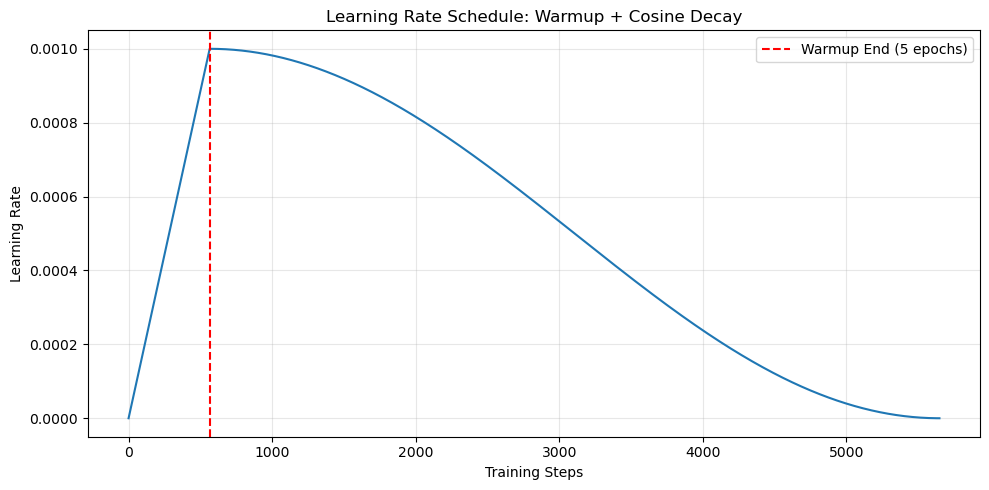

Epoch 1/50 [Train]:   0%|          | 0/113 [00:00<?, ?it/s]c:\Users\danva\anaconda3\envs\fn-pytorch\Lib\site-packages\timm\models\maxxvit.py:189: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  x = torch.nn.functional.scaled_dot_product_attention(
Epoch 1/50 [Train]: 100%|██████████| 113/113 [11:42<00:00,  6.22s/it, loss=1.11, acc=60.9, lr=0.000198, grad_norm=60.7]


Average gradient norm for epoch 1: 114.4524


Epoch 1/50 [Val]: 100%|██████████| 15/15 [00:13<00:00,  1.13it/s, loss=0.588, acc=79.6]


Epoch 1/50 - Train Loss: 1.1111, Train Acc: 60.89%, Val Loss: 0.5876, Val Acc: 79.56%
New best model saved with val accuracy: 79.56%

Classification Report:
                     precision    recall  f1-score   support

          Cardboard       0.93      0.82      0.87        50
      Food Organics       0.90      0.92      0.91        50
              Glass       0.84      0.98      0.91        50
              Metal       0.62      0.86      0.72        50
Miscellaneous Trash       0.57      0.78      0.66        50
              Paper       0.91      0.60      0.72        50
            Plastic       0.77      0.66      0.71        50
      Textile Trash       0.91      0.80      0.85        50
         Vegetation       0.95      0.74      0.83        50

           accuracy                           0.80       450
          macro avg       0.82      0.80      0.80       450
       weighted avg       0.82      0.80      0.80       450



Epoch 2/50 [Train]: 100%|██████████| 113/113 [14:06<00:00,  7.49s/it, loss=0.713, acc=75.7, lr=0.000398, grad_norm=59.1]


Average gradient norm for epoch 2: 38.1784


Epoch 2/50 [Val]: 100%|██████████| 15/15 [00:07<00:00,  2.05it/s, loss=0.706, acc=74.2]


Epoch 2/50 - Train Loss: 0.7126, Train Acc: 75.69%, Val Loss: 0.7056, Val Acc: 74.22%


Epoch 3/50 [Train]: 100%|██████████| 113/113 [04:45<00:00,  2.52s/it, loss=0.785, acc=75, lr=0.000598, grad_norm=19.8]  


Average gradient norm for epoch 3: 26.1822


Epoch 3/50 [Val]: 100%|██████████| 15/15 [00:06<00:00,  2.31it/s, loss=0.632, acc=80.2]


Epoch 3/50 - Train Loss: 0.7845, Train Acc: 74.97%, Val Loss: 0.5902, Val Acc: 80.22%
New best model saved with val accuracy: 80.22%

Classification Report:
                     precision    recall  f1-score   support

          Cardboard       0.70      0.88      0.78        50
      Food Organics       0.82      0.92      0.87        50
              Glass       0.96      0.94      0.95        50
              Metal       0.95      0.72      0.82        50
Miscellaneous Trash       0.62      0.74      0.67        50
              Paper       0.80      0.66      0.73        50
            Plastic       0.71      0.88      0.79        50
      Textile Trash       0.94      0.60      0.73        50
         Vegetation       0.90      0.88      0.89        50

           accuracy                           0.80       450
          macro avg       0.82      0.80      0.80       450
       weighted avg       0.82      0.80      0.80       450



Epoch 4/50 [Train]: 100%|██████████| 113/113 [04:35<00:00,  2.44s/it, loss=0.791, acc=72.8, lr=0.000798, grad_norm=13.9]


Average gradient norm for epoch 4: 18.5833


Epoch 4/50 [Val]: 100%|██████████| 15/15 [00:05<00:00,  2.77it/s, loss=0.907, acc=68.4]


Epoch 4/50 - Train Loss: 0.7909, Train Acc: 72.83%, Val Loss: 0.8464, Val Acc: 68.44%


Epoch 5/50 [Train]: 100%|██████████| 113/113 [04:45<00:00,  2.53s/it, loss=0.867, acc=70.9, lr=0.000998, grad_norm=16.8]


Average gradient norm for epoch 5: 17.0861


Epoch 5/50 [Val]: 100%|██████████| 15/15 [00:05<00:00,  2.52it/s, loss=0.694, acc=75.6]


Epoch 5/50 - Train Loss: 0.8673, Train Acc: 70.86%, Val Loss: 0.6941, Val Acc: 75.56%


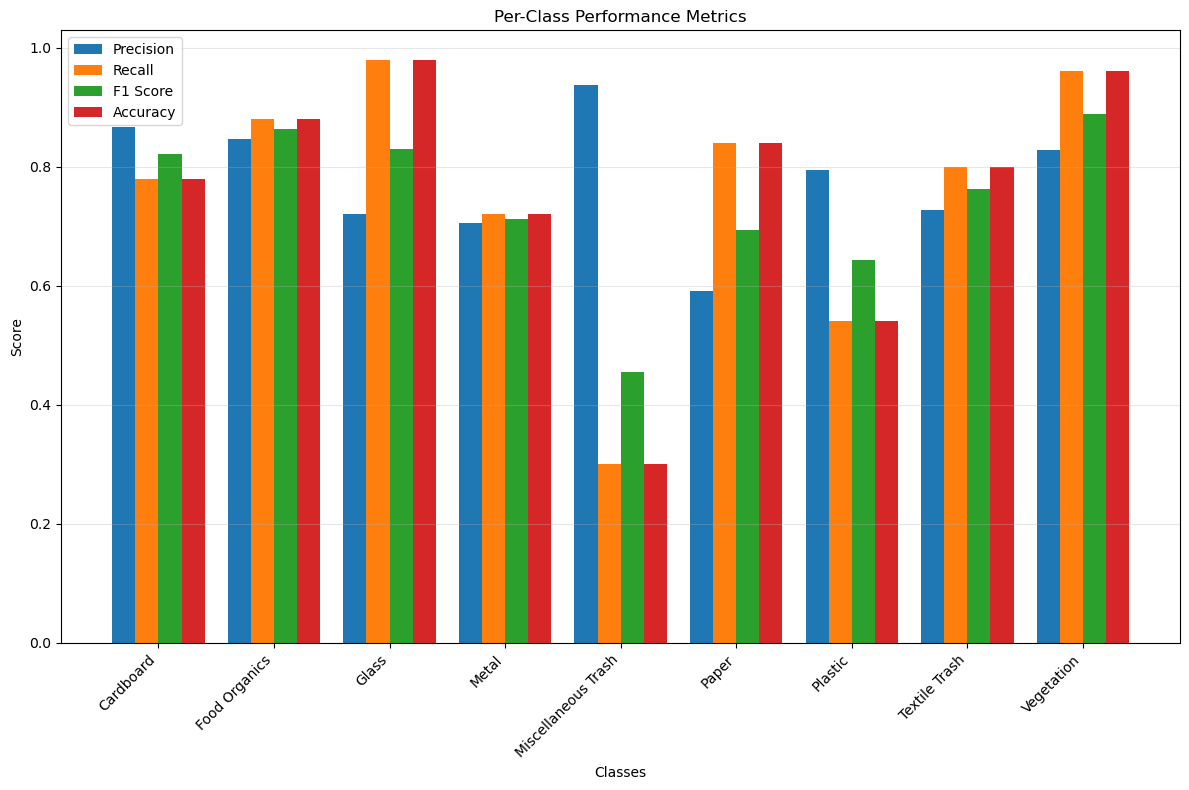

Epoch 6/50 [Train]: 100%|██████████| 113/113 [04:45<00:00,  2.53s/it, loss=0.839, acc=71.5, lr=0.000999, grad_norm=7.06]


Average gradient norm for epoch 6: 13.9181


Epoch 6/50 [Val]: 100%|██████████| 15/15 [00:05<00:00,  2.55it/s, loss=0.854, acc=72]  


Epoch 6/50 - Train Loss: 0.8393, Train Acc: 71.53%, Val Loss: 0.8543, Val Acc: 72.00%


Epoch 7/50 [Train]: 100%|██████████| 113/113 [8:18:32<00:00, 264.71s/it, loss=0.707, acc=75.6, lr=0.000995, grad_norm=18.6]    


Average gradient norm for epoch 7: 11.9299


Epoch 7/50 [Val]: 100%|██████████| 15/15 [00:06<00:00,  2.36it/s, loss=0.665, acc=79.1]


Epoch 7/50 - Train Loss: 0.7066, Train Acc: 75.58%, Val Loss: 0.6206, Val Acc: 79.11%


Epoch 8/50 [Train]: 100%|██████████| 113/113 [01:04<00:00,  1.76it/s, loss=0.693, acc=76.6, lr=0.000989, grad_norm=33.2]


Average gradient norm for epoch 8: 11.8443


Epoch 8/50 [Val]: 100%|██████████| 15/15 [00:05<00:00,  2.62it/s, loss=0.465, acc=83.1]


Epoch 8/50 - Train Loss: 0.6931, Train Acc: 76.61%, Val Loss: 0.4338, Val Acc: 83.11%
New best model saved with val accuracy: 83.11%

Classification Report:
                     precision    recall  f1-score   support

          Cardboard       0.86      0.86      0.86        50
      Food Organics       0.89      0.94      0.91        50
              Glass       0.89      0.94      0.91        50
              Metal       0.72      0.82      0.77        50
Miscellaneous Trash       0.81      0.68      0.74        50
              Paper       0.79      0.82      0.80        50
            Plastic       0.74      0.74      0.74        50
      Textile Trash       0.85      0.88      0.86        50
         Vegetation       0.98      0.80      0.88        50

           accuracy                           0.83       450
          macro avg       0.83      0.83      0.83       450
       weighted avg       0.83      0.83      0.83       450



Epoch 9/50 [Train]: 100%|██████████| 113/113 [01:05<00:00,  1.72it/s, loss=0.655, acc=78.1, lr=0.000981, grad_norm=10.9]


Average gradient norm for epoch 9: 11.5818


Epoch 9/50 [Val]: 100%|██████████| 15/15 [00:06<00:00,  2.15it/s, loss=1.05, acc=71.3]


Epoch 9/50 - Train Loss: 0.6553, Train Acc: 78.14%, Val Loss: 0.9756, Val Acc: 71.33%


Epoch 10/50 [Train]: 100%|██████████| 113/113 [01:05<00:00,  1.72it/s, loss=0.61, acc=78.9, lr=0.00097, grad_norm=15.5]  


Average gradient norm for epoch 10: 10.0445


Epoch 10/50 [Val]: 100%|██████████| 15/15 [00:06<00:00,  2.32it/s, loss=0.514, acc=81.3]


Epoch 10/50 - Train Loss: 0.6103, Train Acc: 78.94%, Val Loss: 0.5144, Val Acc: 81.33%


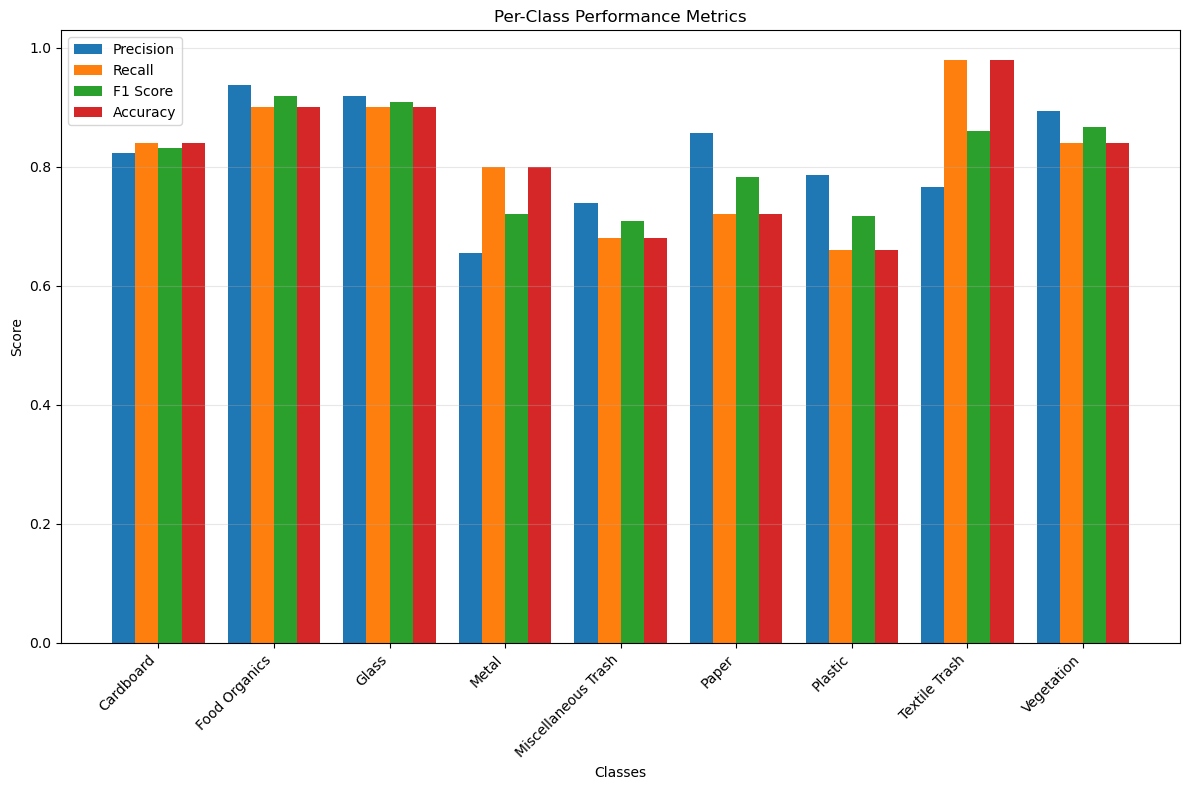

Epoch 11/50 [Train]: 100%|██████████| 113/113 [01:04<00:00,  1.76it/s, loss=0.523, acc=82.7, lr=0.000957, grad_norm=25.2]


Average gradient norm for epoch 11: 9.9103


Epoch 11/50 [Val]: 100%|██████████| 15/15 [00:06<00:00,  2.45it/s, loss=0.91, acc=72.4] 


Epoch 11/50 - Train Loss: 0.5229, Train Acc: 82.67%, Val Loss: 0.9101, Val Acc: 72.44%


Epoch 12/50 [Train]: 100%|██████████| 113/113 [01:01<00:00,  1.84it/s, loss=0.532, acc=81.6, lr=0.000942, grad_norm=18.7]


Average gradient norm for epoch 12: 9.7962


Epoch 12/50 [Val]: 100%|██████████| 15/15 [00:06<00:00,  2.45it/s, loss=0.376, acc=88.7]


Epoch 12/50 - Train Loss: 0.5321, Train Acc: 81.58%, Val Loss: 0.3512, Val Acc: 88.67%
New best model saved with val accuracy: 88.67%

Classification Report:
                     precision    recall  f1-score   support

          Cardboard       0.81      0.94      0.87        50
      Food Organics       0.92      0.96      0.94        50
              Glass       0.94      0.94      0.94        50
              Metal       0.84      0.92      0.88        50
Miscellaneous Trash       0.93      0.74      0.82        50
              Paper       0.83      0.86      0.84        50
            Plastic       0.85      0.80      0.82        50
      Textile Trash       0.91      0.86      0.89        50
         Vegetation       0.98      0.96      0.97        50

           accuracy                           0.89       450
          macro avg       0.89      0.89      0.89       450
       weighted avg       0.89      0.89      0.89       450



Epoch 13/50 [Train]: 100%|██████████| 113/113 [01:01<00:00,  1.85it/s, loss=0.487, acc=83.4, lr=0.000924, grad_norm=14.6]


Average gradient norm for epoch 13: 9.3115


Epoch 13/50 [Val]: 100%|██████████| 15/15 [00:05<00:00,  2.57it/s, loss=0.372, acc=88.7]


Epoch 13/50 - Train Loss: 0.4870, Train Acc: 83.42%, Val Loss: 0.3717, Val Acc: 88.67%


Epoch 14/50 [Train]: 100%|██████████| 113/113 [01:01<00:00,  1.84it/s, loss=0.477, acc=83, lr=0.000905, grad_norm=21.2]  


Average gradient norm for epoch 14: 9.8298


Epoch 14/50 [Val]: 100%|██████████| 15/15 [00:06<00:00,  2.36it/s, loss=0.485, acc=82.4]


Epoch 14/50 - Train Loss: 0.4769, Train Acc: 83.03%, Val Loss: 0.4847, Val Acc: 82.44%


Epoch 15/50 [Train]: 100%|██████████| 113/113 [01:02<00:00,  1.82it/s, loss=0.471, acc=83.5, lr=0.000883, grad_norm=8.22]


Average gradient norm for epoch 15: 8.9778


Epoch 15/50 [Val]: 100%|██████████| 15/15 [00:05<00:00,  2.51it/s, loss=0.426, acc=87.1]


Epoch 15/50 - Train Loss: 0.4713, Train Acc: 83.47%, Val Loss: 0.4265, Val Acc: 87.11%


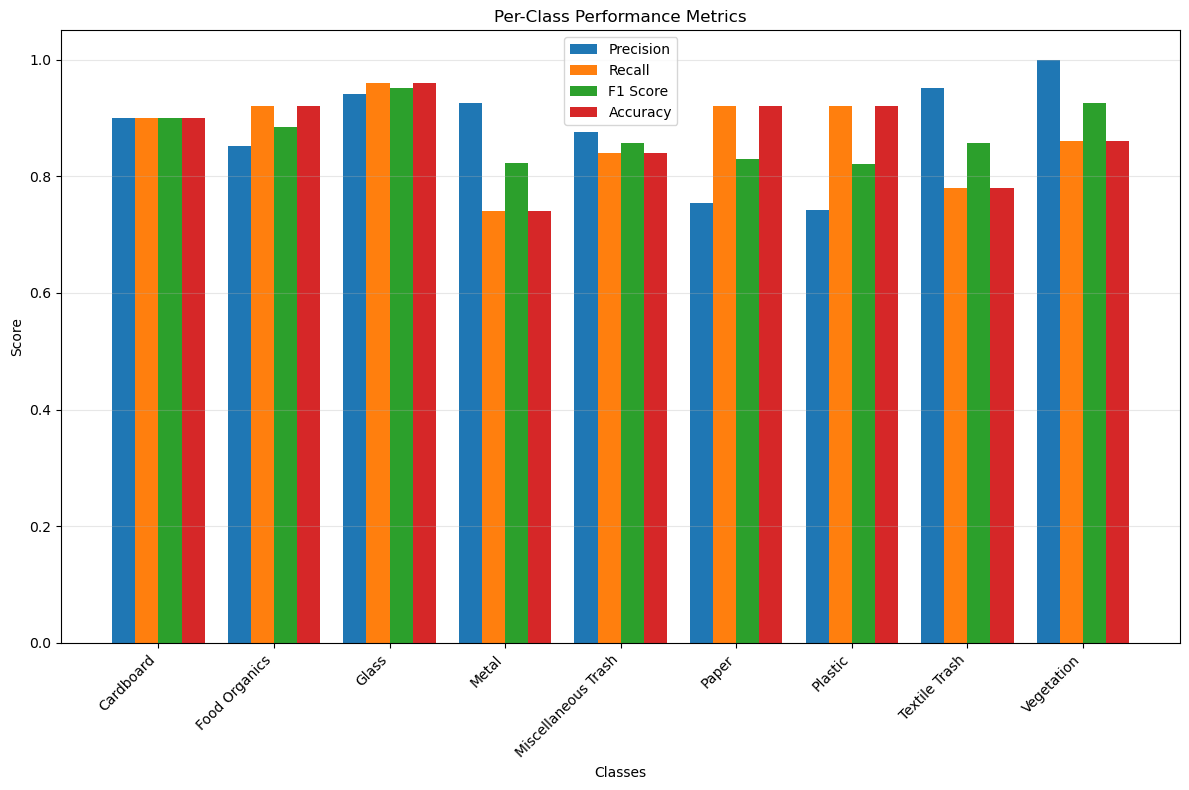

Epoch 16/50 [Train]: 100%|██████████| 113/113 [01:02<00:00,  1.81it/s, loss=0.425, acc=85.1, lr=0.00086, grad_norm=22.1] 


Average gradient norm for epoch 16: 8.5888


Epoch 16/50 [Val]: 100%|██████████| 15/15 [00:06<00:00,  2.39it/s, loss=0.386, acc=87.8]


Epoch 16/50 - Train Loss: 0.4250, Train Acc: 85.11%, Val Loss: 0.3862, Val Acc: 87.78%


Epoch 17/50 [Train]: 100%|██████████| 113/113 [01:01<00:00,  1.84it/s, loss=0.426, acc=85.7, lr=0.000835, grad_norm=5.8] 


Average gradient norm for epoch 17: 7.6242


Epoch 17/50 [Val]: 100%|██████████| 15/15 [00:06<00:00,  2.44it/s, loss=0.52, acc=82]   


Epoch 17/50 - Train Loss: 0.4257, Train Acc: 85.67%, Val Loss: 0.5197, Val Acc: 82.00%


Epoch 18/50 [Train]: 100%|██████████| 113/113 [01:02<00:00,  1.81it/s, loss=0.356, acc=87.8, lr=0.000808, grad_norm=18.6]


Average gradient norm for epoch 18: 7.3875


Epoch 18/50 [Val]: 100%|██████████| 15/15 [00:06<00:00,  2.19it/s, loss=0.271, acc=89.6]


Epoch 18/50 - Train Loss: 0.3561, Train Acc: 87.83%, Val Loss: 0.2709, Val Acc: 89.56%
New best model saved with val accuracy: 89.56%

Classification Report:
                     precision    recall  f1-score   support

          Cardboard       0.90      0.92      0.91        50
      Food Organics       0.88      0.98      0.92        50
              Glass       0.91      0.96      0.93        50
              Metal       0.89      0.80      0.84        50
Miscellaneous Trash       0.86      0.88      0.87        50
              Paper       0.91      0.86      0.89        50
            Plastic       0.91      0.86      0.89        50
      Textile Trash       0.86      0.88      0.87        50
         Vegetation       0.94      0.92      0.93        50

           accuracy                           0.90       450
          macro avg       0.90      0.90      0.89       450
       weighted avg       0.90      0.90      0.89       450



Epoch 19/50 [Train]: 100%|██████████| 113/113 [01:02<00:00,  1.80it/s, loss=0.379, acc=87.1, lr=0.00078, grad_norm=7.73] 


Average gradient norm for epoch 19: 7.1635


Epoch 19/50 [Val]: 100%|██████████| 15/15 [00:06<00:00,  2.31it/s, loss=0.483, acc=84.2]


Epoch 19/50 - Train Loss: 0.3794, Train Acc: 87.06%, Val Loss: 0.4832, Val Acc: 84.22%


Epoch 20/50 [Train]: 100%|██████████| 113/113 [01:04<00:00,  1.75it/s, loss=0.345, acc=87.8, lr=0.00075, grad_norm=16.3] 


Average gradient norm for epoch 20: 7.4037


Epoch 20/50 [Val]: 100%|██████████| 15/15 [00:06<00:00,  2.39it/s, loss=0.373, acc=86.4]


Epoch 20/50 - Train Loss: 0.3447, Train Acc: 87.81%, Val Loss: 0.3734, Val Acc: 86.44%


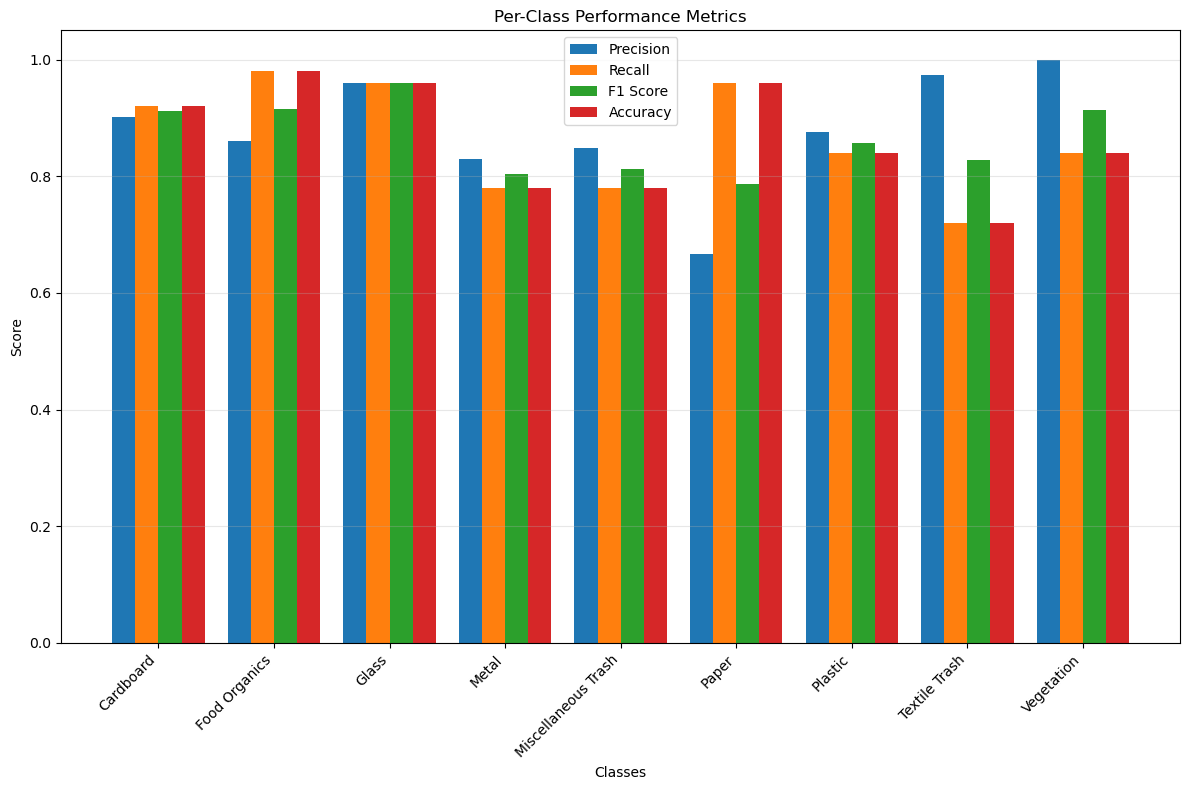

Epoch 21/50 [Train]: 100%|██████████| 113/113 [01:04<00:00,  1.75it/s, loss=0.322, acc=89.5, lr=0.000719, grad_norm=5.6] 


Average gradient norm for epoch 21: 7.0825


Epoch 21/50 [Val]: 100%|██████████| 15/15 [00:06<00:00,  2.50it/s, loss=0.266, acc=90.2]


Epoch 21/50 - Train Loss: 0.3217, Train Acc: 89.47%, Val Loss: 0.2661, Val Acc: 90.22%
New best model saved with val accuracy: 90.22%

Classification Report:
                     precision    recall  f1-score   support

          Cardboard       0.90      0.92      0.91        50
      Food Organics       0.92      0.98      0.95        50
              Glass       0.96      0.96      0.96        50
              Metal       0.94      0.64      0.76        50
Miscellaneous Trash       0.90      0.90      0.90        50
              Paper       0.87      0.96      0.91        50
            Plastic       0.77      0.88      0.82        50
      Textile Trash       0.90      0.94      0.92        50
         Vegetation       0.98      0.94      0.96        50

           accuracy                           0.90       450
          macro avg       0.91      0.90      0.90       450
       weighted avg       0.91      0.90      0.90       450



Epoch 22/50 [Train]: 100%|██████████| 113/113 [01:03<00:00,  1.77it/s, loss=0.314, acc=89.4, lr=0.000688, grad_norm=8.95]


Average gradient norm for epoch 22: 7.0286


Epoch 22/50 [Val]: 100%|██████████| 15/15 [00:05<00:00,  2.57it/s, loss=0.449, acc=85.3]


Epoch 22/50 - Train Loss: 0.3142, Train Acc: 89.44%, Val Loss: 0.4486, Val Acc: 85.33%


Epoch 23/50 [Train]: 100%|██████████| 113/113 [01:04<00:00,  1.75it/s, loss=0.257, acc=90.9, lr=0.000655, grad_norm=5.69]


Average gradient norm for epoch 23: 6.7663


Epoch 23/50 [Val]: 100%|██████████| 15/15 [00:06<00:00,  2.39it/s, loss=0.427, acc=86.2]


Epoch 23/50 - Train Loss: 0.2568, Train Acc: 90.92%, Val Loss: 0.4270, Val Acc: 86.22%


Epoch 24/50 [Train]: 100%|██████████| 113/113 [01:03<00:00,  1.79it/s, loss=0.268, acc=91.3, lr=0.000621, grad_norm=9.25]


Average gradient norm for epoch 24: 6.0057


Epoch 24/50 [Val]: 100%|██████████| 15/15 [00:06<00:00,  2.34it/s, loss=0.348, acc=90.9]


Epoch 24/50 - Train Loss: 0.2680, Train Acc: 91.31%, Val Loss: 0.3482, Val Acc: 90.89%
New best model saved with val accuracy: 90.89%

Classification Report:
                     precision    recall  f1-score   support

          Cardboard       0.98      0.90      0.94        50
      Food Organics       0.98      0.82      0.89        50
              Glass       0.94      0.94      0.94        50
              Metal       0.88      0.76      0.82        50
Miscellaneous Trash       0.88      0.92      0.90        50
              Paper       0.86      0.98      0.92        50
            Plastic       0.80      0.90      0.85        50
      Textile Trash       0.96      0.98      0.97        50
         Vegetation       0.92      0.98      0.95        50

           accuracy                           0.91       450
          macro avg       0.91      0.91      0.91       450
       weighted avg       0.91      0.91      0.91       450



Epoch 25/50 [Train]: 100%|██████████| 113/113 [01:01<00:00,  1.85it/s, loss=0.258, acc=91.6, lr=0.000587, grad_norm=7.04]


Average gradient norm for epoch 25: 6.4395


Epoch 25/50 [Val]: 100%|██████████| 15/15 [00:05<00:00,  2.53it/s, loss=0.324, acc=88.9]


Epoch 25/50 - Train Loss: 0.2582, Train Acc: 91.61%, Val Loss: 0.3243, Val Acc: 88.89%


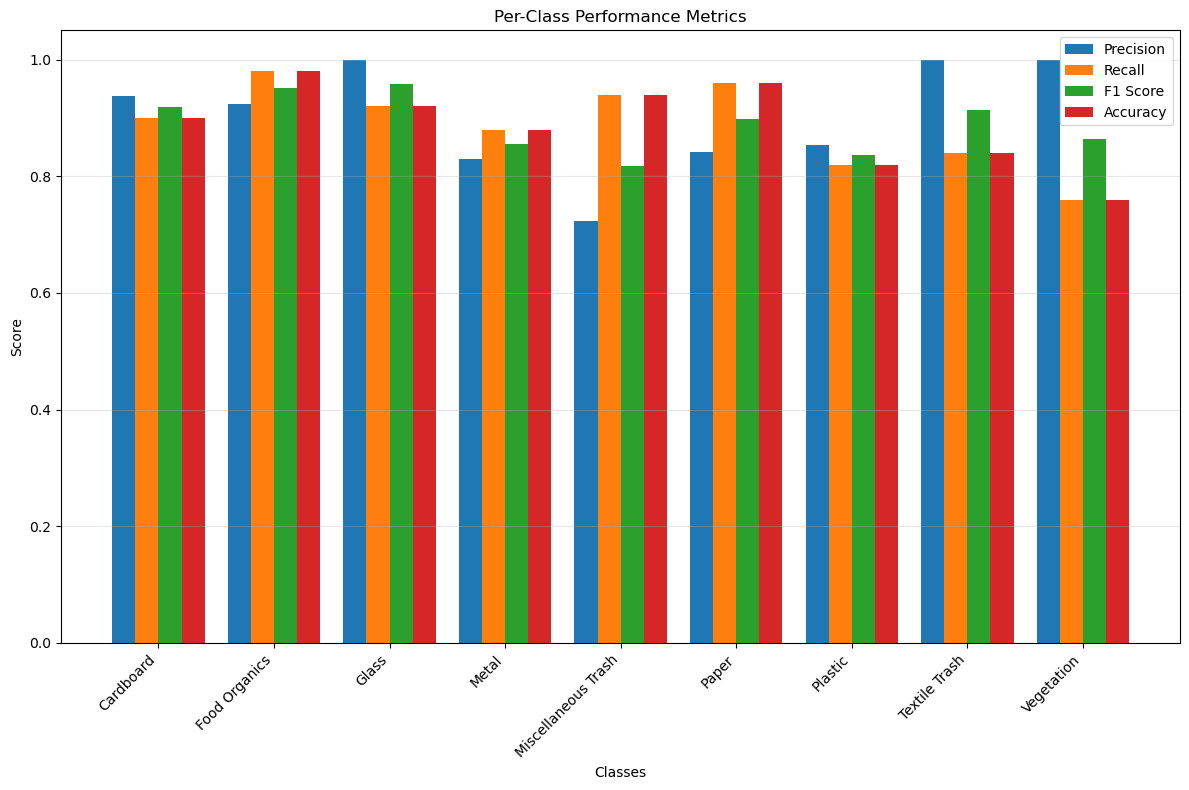

Epoch 26/50 [Train]: 100%|██████████| 113/113 [01:01<00:00,  1.85it/s, loss=0.229, acc=92, lr=0.000553, grad_norm=2.42]  


Average gradient norm for epoch 26: 5.8953


Epoch 26/50 [Val]: 100%|██████████| 15/15 [00:05<00:00,  2.51it/s, loss=0.25, acc=93.6] 


Epoch 26/50 - Train Loss: 0.2289, Train Acc: 92.03%, Val Loss: 0.2331, Val Acc: 93.56%
New best model saved with val accuracy: 93.56%

Classification Report:
                     precision    recall  f1-score   support

          Cardboard       0.98      0.88      0.93        50
      Food Organics       0.89      1.00      0.94        50
              Glass       0.98      0.96      0.97        50
              Metal       0.94      0.88      0.91        50
Miscellaneous Trash       0.94      0.94      0.94        50
              Paper       0.92      0.96      0.94        50
            Plastic       0.82      0.90      0.86        50
      Textile Trash       0.98      0.94      0.96        50
         Vegetation       1.00      0.96      0.98        50

           accuracy                           0.94       450
          macro avg       0.94      0.94      0.94       450
       weighted avg       0.94      0.94      0.94       450



Epoch 27/50 [Train]: 100%|██████████| 113/113 [01:01<00:00,  1.84it/s, loss=0.214, acc=92.6, lr=0.000518, grad_norm=9.83]


Average gradient norm for epoch 27: 6.3056


Epoch 27/50 [Val]: 100%|██████████| 15/15 [00:06<00:00,  2.41it/s, loss=0.297, acc=91.3]


Epoch 27/50 - Train Loss: 0.2144, Train Acc: 92.56%, Val Loss: 0.2969, Val Acc: 91.33%


Epoch 28/50 [Train]: 100%|██████████| 113/113 [01:03<00:00,  1.79it/s, loss=0.188, acc=93.3, lr=0.000483, grad_norm=8.84]


Average gradient norm for epoch 28: 5.8666


Epoch 28/50 [Val]: 100%|██████████| 15/15 [00:06<00:00,  2.38it/s, loss=0.321, acc=90.2]


Epoch 28/50 - Train Loss: 0.1877, Train Acc: 93.31%, Val Loss: 0.3205, Val Acc: 90.22%


Epoch 29/50 [Train]: 100%|██████████| 113/113 [01:05<00:00,  1.74it/s, loss=0.183, acc=93.3, lr=0.000448, grad_norm=0.883]


Average gradient norm for epoch 29: 5.8393


Epoch 29/50 [Val]: 100%|██████████| 15/15 [00:06<00:00,  2.45it/s, loss=0.164, acc=94.9]


Epoch 29/50 - Train Loss: 0.1830, Train Acc: 93.33%, Val Loss: 0.1636, Val Acc: 94.89%
New best model saved with val accuracy: 94.89%

Classification Report:
                     precision    recall  f1-score   support

          Cardboard       1.00      0.92      0.96        50
      Food Organics       0.94      1.00      0.97        50
              Glass       0.98      0.96      0.97        50
              Metal       0.90      0.94      0.92        50
Miscellaneous Trash       0.96      0.94      0.95        50
              Paper       0.90      0.94      0.92        50
            Plastic       0.87      0.92      0.89        50
      Textile Trash       1.00      0.96      0.98        50
         Vegetation       1.00      0.96      0.98        50

           accuracy                           0.95       450
          macro avg       0.95      0.95      0.95       450
       weighted avg       0.95      0.95      0.95       450



Epoch 30/50 [Train]: 100%|██████████| 113/113 [01:03<00:00,  1.78it/s, loss=0.176, acc=94.1, lr=0.000413, grad_norm=16.1]


Average gradient norm for epoch 30: 5.6899


Epoch 30/50 [Val]: 100%|██████████| 15/15 [00:06<00:00,  2.42it/s, loss=0.223, acc=93.3]


Epoch 30/50 - Train Loss: 0.1762, Train Acc: 94.06%, Val Loss: 0.2227, Val Acc: 93.33%


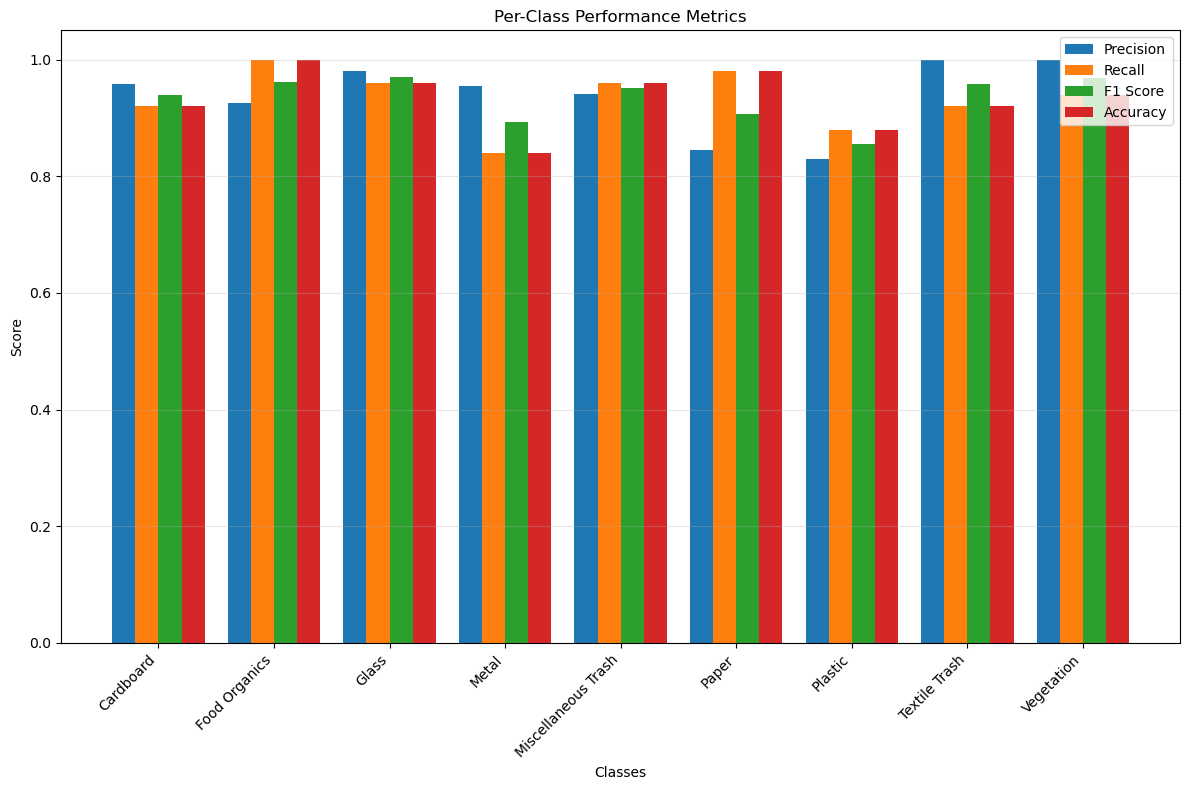

Epoch 31/50 [Train]: 100%|██████████| 113/113 [01:05<00:00,  1.73it/s, loss=0.142, acc=95.4, lr=0.000379, grad_norm=3.06]


Average gradient norm for epoch 31: 4.9802


Epoch 31/50 [Val]: 100%|██████████| 15/15 [00:07<00:00,  2.09it/s, loss=0.23, acc=93.8] 


Epoch 31/50 - Train Loss: 0.1417, Train Acc: 95.42%, Val Loss: 0.2296, Val Acc: 93.78%


Epoch 32/50 [Train]: 100%|██████████| 113/113 [01:04<00:00,  1.75it/s, loss=0.138, acc=95.4, lr=0.000346, grad_norm=7.89]


Average gradient norm for epoch 32: 5.0986


Epoch 32/50 [Val]: 100%|██████████| 15/15 [00:06<00:00,  2.17it/s, loss=0.228, acc=93.8]


Epoch 32/50 - Train Loss: 0.1384, Train Acc: 95.44%, Val Loss: 0.2279, Val Acc: 93.78%


Epoch 33/50 [Train]: 100%|██████████| 113/113 [01:03<00:00,  1.78it/s, loss=0.114, acc=95.7, lr=0.000313, grad_norm=0.413]


Average gradient norm for epoch 33: 4.6017


Epoch 33/50 [Val]: 100%|██████████| 15/15 [00:06<00:00,  2.40it/s, loss=0.172, acc=95.1]


Epoch 33/50 - Train Loss: 0.1138, Train Acc: 95.67%, Val Loss: 0.1718, Val Acc: 95.11%
New best model saved with val accuracy: 95.11%

Classification Report:
                     precision    recall  f1-score   support

          Cardboard       1.00      0.92      0.96        50
      Food Organics       0.94      1.00      0.97        50
              Glass       0.98      1.00      0.99        50
              Metal       0.88      0.92      0.90        50
Miscellaneous Trash       0.98      0.94      0.96        50
              Paper       0.94      0.94      0.94        50
            Plastic       0.92      0.92      0.92        50
      Textile Trash       0.92      0.98      0.95        50
         Vegetation       1.00      0.94      0.97        50

           accuracy                           0.95       450
          macro avg       0.95      0.95      0.95       450
       weighted avg       0.95      0.95      0.95       450



Epoch 34/50 [Train]: 100%|██████████| 113/113 [01:03<00:00,  1.77it/s, loss=0.136, acc=95.6, lr=0.000281, grad_norm=2.53] 


Average gradient norm for epoch 34: 4.6749


Epoch 34/50 [Val]: 100%|██████████| 15/15 [00:06<00:00,  2.38it/s, loss=0.223, acc=94.7]


Epoch 34/50 - Train Loss: 0.1360, Train Acc: 95.61%, Val Loss: 0.2225, Val Acc: 94.67%


Epoch 35/50 [Train]: 100%|██████████| 113/113 [01:02<00:00,  1.81it/s, loss=0.0954, acc=97, lr=0.00025, grad_norm=8.48]    


Average gradient norm for epoch 35: 4.0809


Epoch 35/50 [Val]: 100%|██████████| 15/15 [00:06<00:00,  2.40it/s, loss=0.224, acc=93.8]


Epoch 35/50 - Train Loss: 0.0954, Train Acc: 97.00%, Val Loss: 0.2241, Val Acc: 93.78%


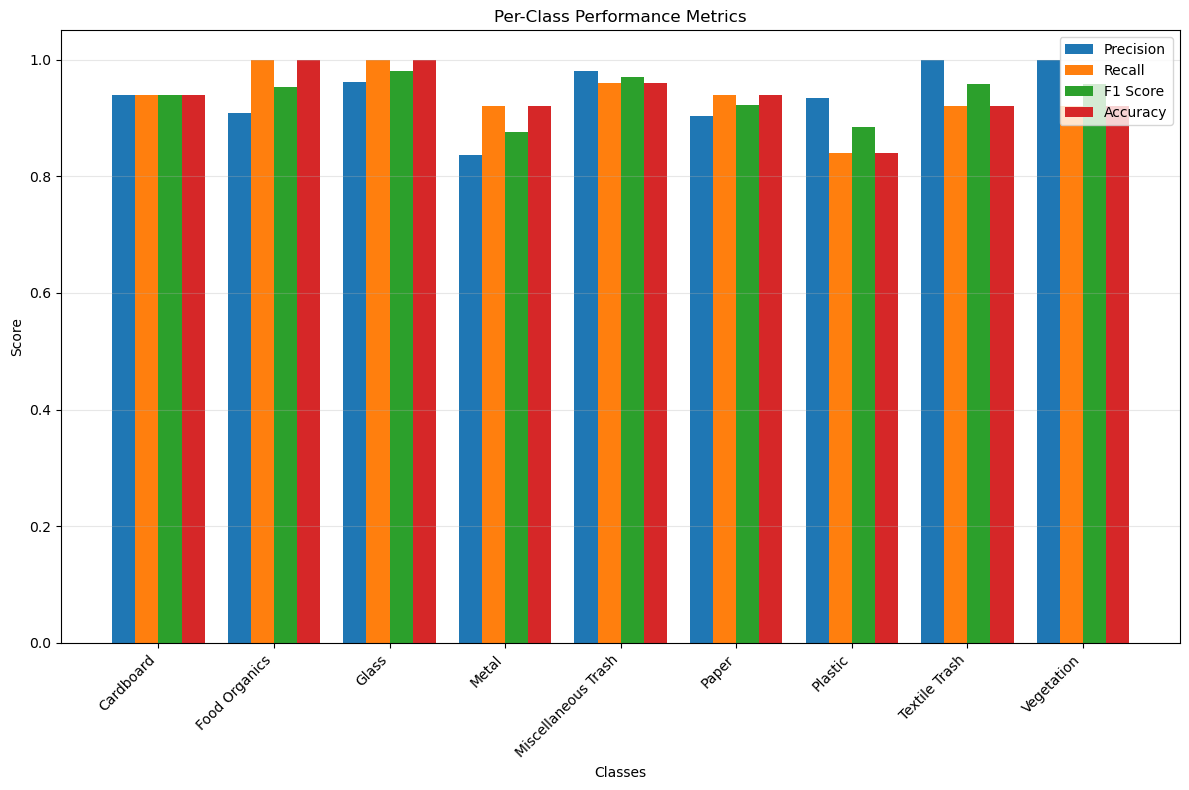

Epoch 36/50 [Train]: 100%|██████████| 113/113 [01:06<00:00,  1.71it/s, loss=0.0957, acc=96.7, lr=0.000221, grad_norm=9.19] 


Average gradient norm for epoch 36: 3.8534


Epoch 36/50 [Val]: 100%|██████████| 15/15 [00:06<00:00,  2.41it/s, loss=0.216, acc=95.1]


Epoch 36/50 - Train Loss: 0.0957, Train Acc: 96.72%, Val Loss: 0.2163, Val Acc: 95.11%


Epoch 37/50 [Train]: 100%|██████████| 113/113 [01:03<00:00,  1.79it/s, loss=0.0832, acc=97.1, lr=0.000192, grad_norm=1.82] 


Average gradient norm for epoch 37: 3.9028


Epoch 37/50 [Val]: 100%|██████████| 15/15 [00:06<00:00,  2.35it/s, loss=0.21, acc=95.8] 


Epoch 37/50 - Train Loss: 0.0832, Train Acc: 97.11%, Val Loss: 0.2105, Val Acc: 95.78%
New best model saved with val accuracy: 95.78%

Classification Report:
                     precision    recall  f1-score   support

          Cardboard       1.00      0.94      0.97        50
      Food Organics       0.93      1.00      0.96        50
              Glass       0.98      1.00      0.99        50
              Metal       0.90      0.92      0.91        50
Miscellaneous Trash       0.96      0.96      0.96        50
              Paper       0.96      1.00      0.98        50
            Plastic       0.90      0.88      0.89        50
      Textile Trash       1.00      0.96      0.98        50
         Vegetation       1.00      0.96      0.98        50

           accuracy                           0.96       450
          macro avg       0.96      0.96      0.96       450
       weighted avg       0.96      0.96      0.96       450



Epoch 38/50 [Train]: 100%|██████████| 113/113 [01:04<00:00,  1.77it/s, loss=0.068, acc=97.9, lr=0.000166, grad_norm=1.21]  


Average gradient norm for epoch 38: 3.2058


Epoch 38/50 [Val]: 100%|██████████| 15/15 [00:06<00:00,  2.46it/s, loss=0.208, acc=94.9]


Epoch 38/50 - Train Loss: 0.0680, Train Acc: 97.89%, Val Loss: 0.2078, Val Acc: 94.89%


Epoch 39/50 [Train]: 100%|██████████| 113/113 [01:03<00:00,  1.77it/s, loss=0.0734, acc=97.5, lr=0.000141, grad_norm=2.34] 


Average gradient norm for epoch 39: 3.3212


Epoch 39/50 [Val]: 100%|██████████| 15/15 [00:06<00:00,  2.38it/s, loss=0.21, acc=95.3] 


Epoch 39/50 - Train Loss: 0.0734, Train Acc: 97.47%, Val Loss: 0.2101, Val Acc: 95.33%


Epoch 40/50 [Train]: 100%|██████████| 113/113 [01:04<00:00,  1.74it/s, loss=0.073, acc=97.4, lr=0.000117, grad_norm=0.182] 


Average gradient norm for epoch 40: 3.4676


Epoch 40/50 [Val]: 100%|██████████| 15/15 [00:06<00:00,  2.37it/s, loss=0.158, acc=95.8]


Epoch 40/50 - Train Loss: 0.0730, Train Acc: 97.42%, Val Loss: 0.1576, Val Acc: 95.78%


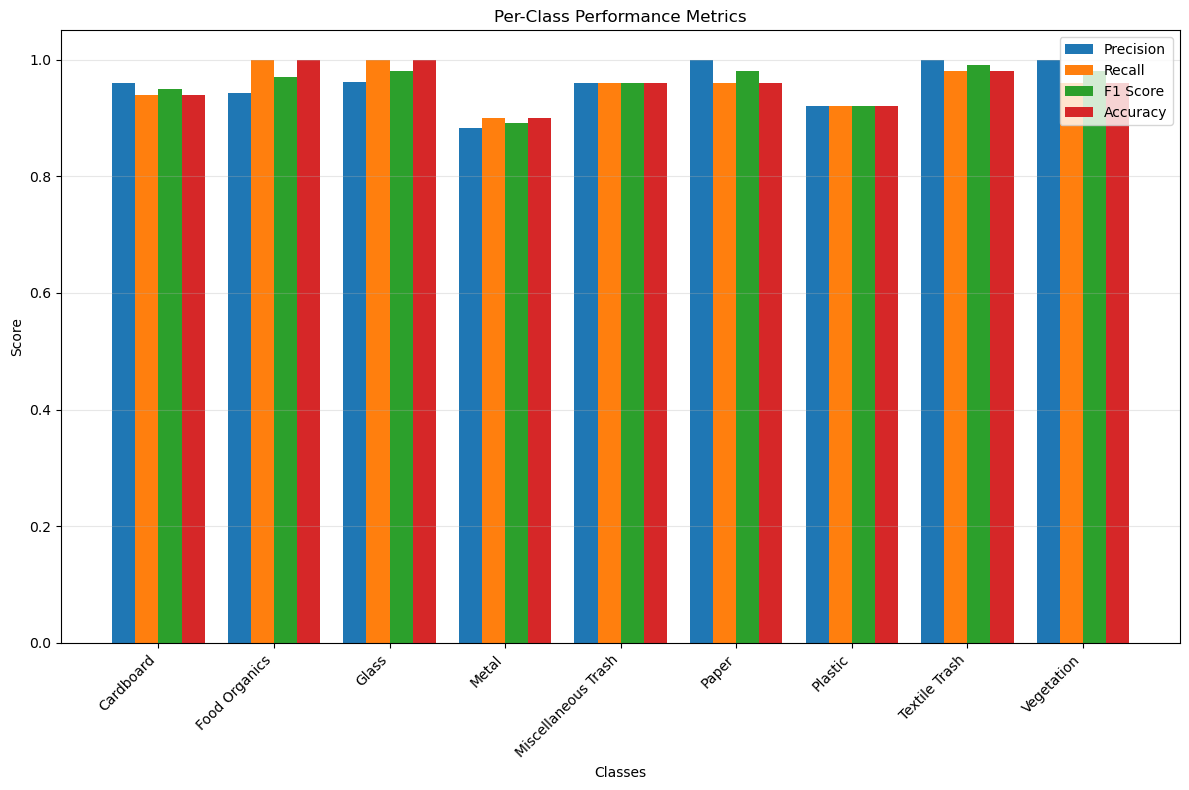

Epoch 41/50 [Train]: 100%|██████████| 113/113 [01:06<00:00,  1.71it/s, loss=0.0657, acc=97.8, lr=9.57e-5, grad_norm=0.0217]


Average gradient norm for epoch 41: 2.9021


Epoch 41/50 [Val]: 100%|██████████| 15/15 [00:06<00:00,  2.40it/s, loss=0.156, acc=96.4]


Epoch 41/50 - Train Loss: 0.0657, Train Acc: 97.83%, Val Loss: 0.1563, Val Acc: 96.44%
New best model saved with val accuracy: 96.44%

Classification Report:
                     precision    recall  f1-score   support

          Cardboard       1.00      0.92      0.96        50
      Food Organics       0.96      1.00      0.98        50
              Glass       0.94      1.00      0.97        50
              Metal       0.90      0.90      0.90        50
Miscellaneous Trash       1.00      0.98      0.99        50
              Paper       0.96      1.00      0.98        50
            Plastic       0.92      0.92      0.92        50
      Textile Trash       1.00      1.00      1.00        50
         Vegetation       1.00      0.96      0.98        50

           accuracy                           0.96       450
          macro avg       0.97      0.96      0.96       450
       weighted avg       0.97      0.96      0.96       450



Epoch 42/50 [Train]: 100%|██████████| 113/113 [01:03<00:00,  1.79it/s, loss=0.0545, acc=98.3, lr=7.61e-5, grad_norm=0.653]


Average gradient norm for epoch 42: 2.2200


Epoch 42/50 [Val]: 100%|██████████| 15/15 [00:06<00:00,  2.35it/s, loss=0.172, acc=96.4]


Epoch 42/50 - Train Loss: 0.0545, Train Acc: 98.31%, Val Loss: 0.1602, Val Acc: 96.44%


Epoch 43/50 [Train]: 100%|██████████| 113/113 [01:04<00:00,  1.76it/s, loss=0.0367, acc=98.8, lr=5.87e-5, grad_norm=0.0413]


Average gradient norm for epoch 43: 1.9566


Epoch 43/50 [Val]: 100%|██████████| 15/15 [00:06<00:00,  2.41it/s, loss=0.172, acc=96.7]


Epoch 43/50 - Train Loss: 0.0367, Train Acc: 98.81%, Val Loss: 0.1723, Val Acc: 96.67%
New best model saved with val accuracy: 96.67%

Classification Report:
                     precision    recall  f1-score   support

          Cardboard       0.98      0.92      0.95        50
      Food Organics       0.94      1.00      0.97        50
              Glass       0.96      1.00      0.98        50
              Metal       0.90      0.92      0.91        50
Miscellaneous Trash       1.00      0.98      0.99        50
              Paper       0.98      1.00      0.99        50
            Plastic       0.94      0.94      0.94        50
      Textile Trash       1.00      1.00      1.00        50
         Vegetation       1.00      0.94      0.97        50

           accuracy                           0.97       450
          macro avg       0.97      0.97      0.97       450
       weighted avg       0.97      0.97      0.97       450



Epoch 44/50 [Train]: 100%|██████████| 113/113 [01:06<00:00,  1.71it/s, loss=0.0463, acc=98.5, lr=4.34e-5, grad_norm=0.00669]


Average gradient norm for epoch 44: 2.3929


Epoch 44/50 [Val]: 100%|██████████| 15/15 [00:07<00:00,  2.09it/s, loss=0.169, acc=96.4]


Epoch 44/50 - Train Loss: 0.0463, Train Acc: 98.47%, Val Loss: 0.1695, Val Acc: 96.44%


Epoch 45/50 [Train]: 100%|██████████| 113/113 [01:04<00:00,  1.75it/s, loss=0.051, acc=98.3, lr=3.03e-5, grad_norm=1.54]   


Average gradient norm for epoch 45: 2.7663


Epoch 45/50 [Val]: 100%|██████████| 15/15 [00:07<00:00,  2.06it/s, loss=0.179, acc=96.4]


Epoch 45/50 - Train Loss: 0.0510, Train Acc: 98.28%, Val Loss: 0.1788, Val Acc: 96.44%


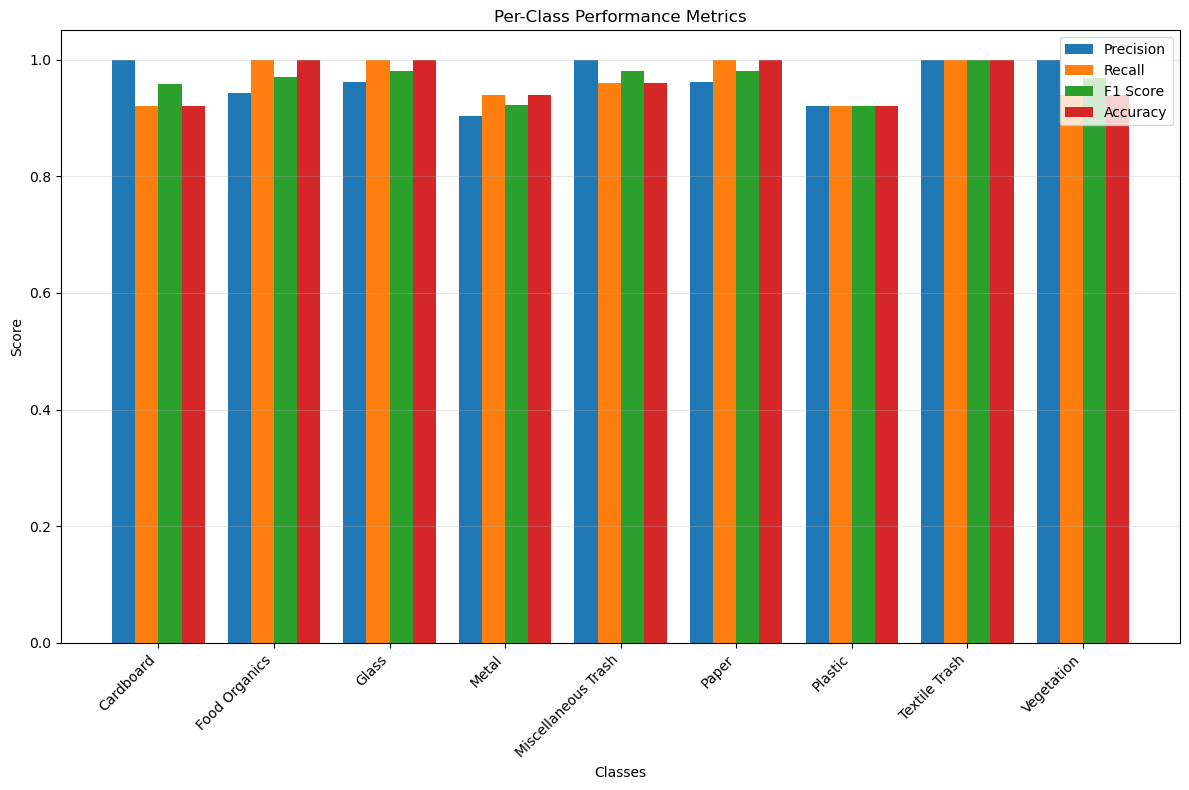

Epoch 46/50 [Train]: 100%|██████████| 113/113 [01:04<00:00,  1.75it/s, loss=0.0443, acc=98.3, lr=1.95e-5, grad_norm=15.4]  


Average gradient norm for epoch 46: 2.3000


Epoch 46/50 [Val]: 100%|██████████| 15/15 [00:06<00:00,  2.35it/s, loss=0.179, acc=96.2]


Epoch 46/50 - Train Loss: 0.0443, Train Acc: 98.33%, Val Loss: 0.1792, Val Acc: 96.22%


Epoch 47/50 [Train]: 100%|██████████| 113/113 [01:08<00:00,  1.64it/s, loss=0.0523, acc=98.5, lr=1.1e-5, grad_norm=0.0519]


Average gradient norm for epoch 47: 2.5186


Epoch 47/50 [Val]: 100%|██████████| 15/15 [00:06<00:00,  2.47it/s, loss=0.181, acc=96.2]


Epoch 47/50 - Train Loss: 0.0523, Train Acc: 98.53%, Val Loss: 0.1810, Val Acc: 96.22%


Epoch 48/50 [Train]: 100%|██████████| 113/113 [01:04<00:00,  1.74it/s, loss=0.048, acc=98.5, lr=4.91e-6, grad_norm=2.67]  


Average gradient norm for epoch 48: 2.4845


Epoch 48/50 [Val]: 100%|██████████| 15/15 [00:06<00:00,  2.32it/s, loss=0.19, acc=96.2] 


Epoch 48/50 - Train Loss: 0.0480, Train Acc: 98.50%, Val Loss: 0.1777, Val Acc: 96.22%


Epoch 49/50 [Train]: 100%|██████████| 113/113 [01:03<00:00,  1.77it/s, loss=0.0407, acc=98.7, lr=1.24e-6, grad_norm=2.05] 


Average gradient norm for epoch 49: 2.2123


Epoch 49/50 [Val]: 100%|██████████| 15/15 [00:06<00:00,  2.34it/s, loss=0.172, acc=96.2]


Epoch 49/50 - Train Loss: 0.0407, Train Acc: 98.69%, Val Loss: 0.1724, Val Acc: 96.22%


Epoch 50/50 [Train]: 100%|██████████| 113/113 [01:03<00:00,  1.78it/s, loss=0.0431, acc=98.6, lr=9.54e-11, grad_norm=0.301]


Average gradient norm for epoch 50: 1.9263


Epoch 50/50 [Val]: 100%|██████████| 15/15 [00:06<00:00,  2.34it/s, loss=0.195, acc=96]  


Epoch 50/50 - Train Loss: 0.0431, Train Acc: 98.58%, Val Loss: 0.1822, Val Acc: 96.00%


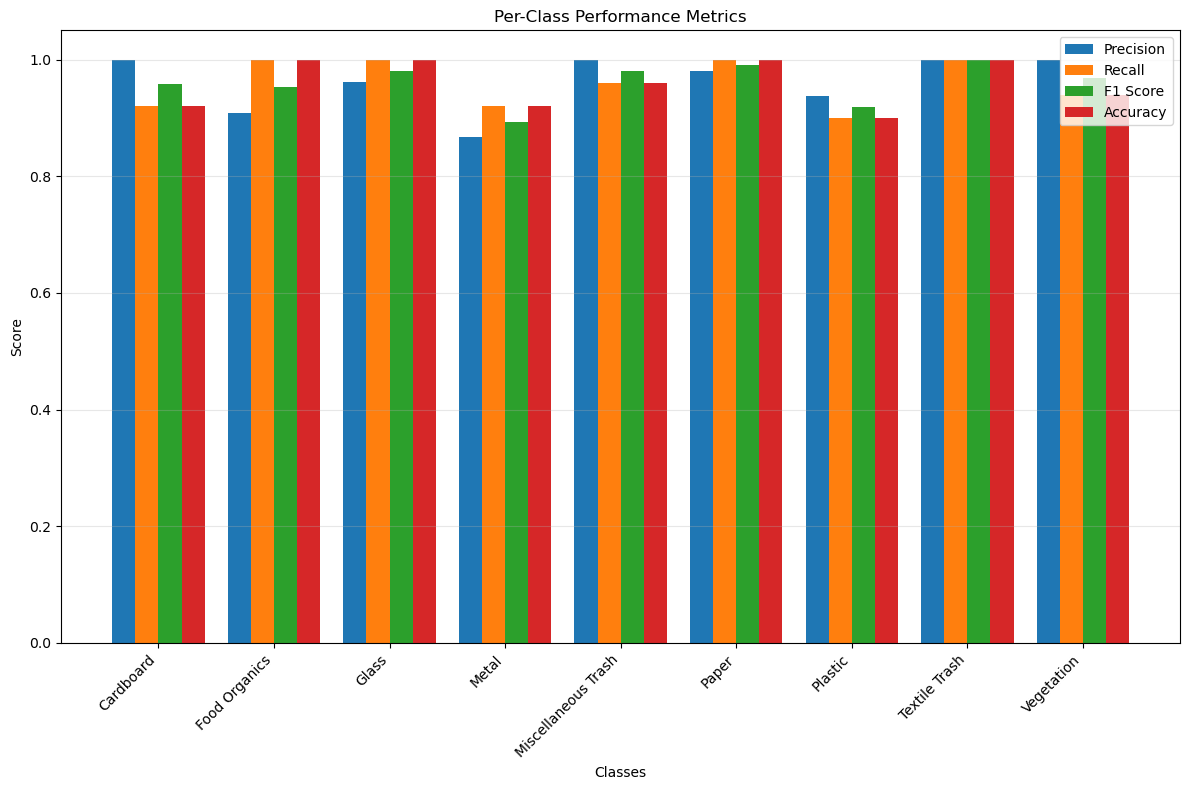

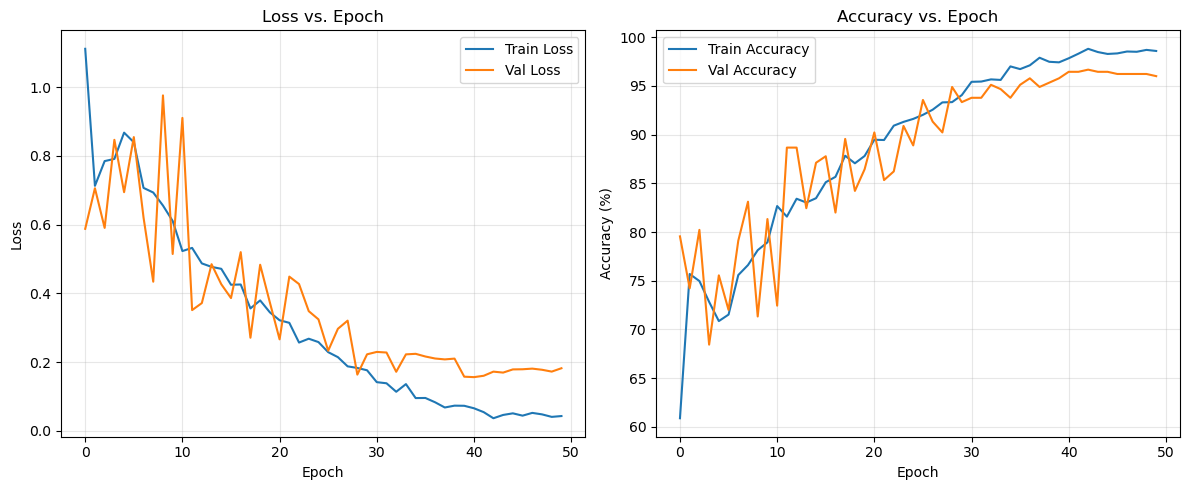

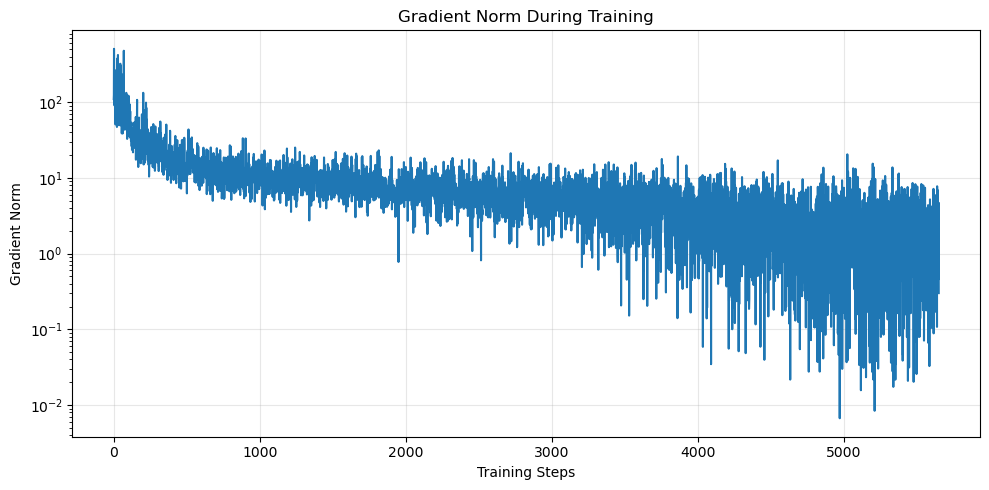

Training completed! Best validation accuracy: 96.67%


In [20]:
model, best_val_acc = train_model()
print(f"Training completed! Best validation accuracy: {best_val_acc:.2f}%")